# Zona incerta region (ZIR) structural connectivity

## Python libraries

In [40]:
import numpy as np
import nibabel as nib
import nilearn.plotting, nilearn.surface
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances_argmin
import pandas as pd
import os

In [2]:
# Create custom colour map
from matplotlib.colors import ListedColormap

cb_color_cycle = [
    "#d3d3d3",   # Grey 
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]

## Variables

In [22]:
# Surface variables
lh_mmp = nilearn.surface.load_surf_data("../subcorticalparc_smk/resources/lh.HCPMMP1.annot")
#rh_mmp = nilearn.surface.load_surf_data("../resources/rh.HCPMMP1.annot")

lh_mmp.shape

(163842,)

In [59]:
#load cortical dseg data
cortical_dseg = nib.load('../subcorticalparc_smk/results/diffparc/sub-exvivo/sub-exvivo_space-individual_res-dwi_label-paxinos_dseg.nii.gz')

cortical_dseg_vol = cortical_dseg.get_fdata()
cortical_dseg_flat = cortical_dseg_vol.flatten()
cortical_dseg_flat.shape

(6300000,)

## Analysis

### Left
#### Target

In [15]:
data_L = np.load(f"../subcorticalparc_smk/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-L_label-ZIR_desc-concat_from-group_connMap.npz");

conn_group_L = data_L['conn_group']
mask_L = data_L['mask']
affine_L = data_L['affine']

# Concat subjects
conn_group_m_L = np.moveaxis(conn_group_L, 0, 2)
conn_concat_L = conn_group_m_L.reshape(
    [conn_group_m_L.shape[0], conn_group_m_L.shape[1]*conn_group_m_L.shape[2]]
)

In [16]:
# Run spectral clustering
method = 'spectralcosine'
dist = 'cosine'
k = 6 #@param {type:"slider", min:0, max:50, step:1}

clustering_L = SpectralClustering(
    n_clusters=k, 
    assign_labels="discretize",
    random_state=1,
    affinity=dist,
).fit(conn_concat_L)

In [17]:
# avg over subjects (for cluster centroid visualization over cortex)
conn_avg_L =  np.squeeze(np.mean(conn_group_m_L, 2))

# Cluster
ntargets_L = conn_group_L.shape[2]
centroids_L = np.zeros((k,ntargets_L))

print(f"shape conn_avg: {conn_avg_L.shape}")
print(f"shape conn_concat: {conn_concat_L.shape}")

shape conn_avg: (865, 116)
shape conn_concat: (865, 116)


In [65]:
df_paxinos

,label_num,name
0,1,A1_2
1,2,A10
2,3,A11
3,4,A13L
4,5,A13M
...,...,...
111,131,V4T
112,132,V5
113,133,V6
114,134,V6A


/tmp/ipykernel_311660/3633250052.py:18: RuntimeWarning: divide by zero encountered in log
  cortconn_flat[cortical_dseg_flat == paxinos_lut[i-1] ] = np.log(conn)


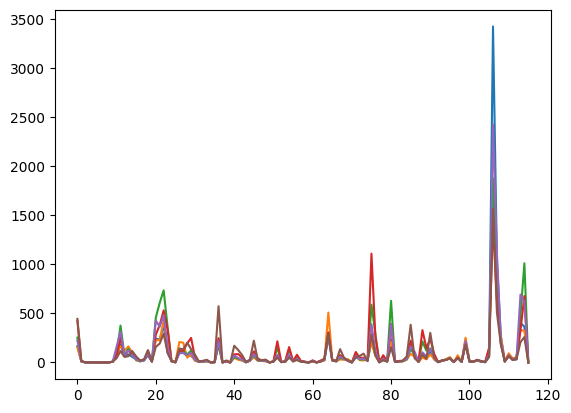

In [66]:
# Get features for each label and average over voxwels


df_paxinos = pd.read_csv('../subcorticalparc_smk/resources/label-paxinos_dseg.tsv',sep='\t')
paxinos_lut = df_paxinos.label_num.to_numpy()
paxinos_lut

cortconn_flat = np.zeros(cortical_dseg_flat.shape)


for kidx in range(k):
    centroids_L[kidx][:] = np.mean(conn_avg_L[clustering_L.labels_ == kidx][:], axis=0)
    
    # Plot for centroid
    plt.plot(centroids_L[kidx])

    for i,conn in enumerate(centroids_L[kidx][:]):
        cortconn_flat[cortical_dseg_flat == paxinos_lut[i-1] ] = np.log(conn)

    cortconn_vol = cortconn_flat.reshape(cortical_dseg_vol.shape)

    cortconn_vol.shape
    cortconn_nib = nib.Nifti1Image(cortconn_vol,header=cortical_dseg.header,affine=cortical_dseg.affine)
    cortconn_nib.to_filename(f'sub-exvivo_clus-{kidx}_k-{k}_desc-log10_centroid.nii.gz')

# use lh_mmp to map to the maximal region from each centroid
#target_labels_L = np.argmax(centroids_L, 0) + 1

#lh_mmp indices are from 1 to 180 (0 is bgnd), so:
#centroid_cortex_L = target_labels_L[lh_mmp-1]
#centroid_cortex_L[np.argwhere(lh_mmp == 0)] = 0


In [27]:
# Download fsaverage surface
#fsaverage_data = nilearn.datasets.fetch_surf_fsaverage(
#    mesh="fsaverage",
#    data_dir="../resources/fsaverage"
#)

#### Seed

In [59]:
seed_labels_vol_L = np.zeros(mask_L.shape)
seed_labels_vol_L[mask_L > 0] = clustering_L.labels_ + 1 #add a 1 so label 0 is diff from bgnd
seed_labels_nib_L = nib.Nifti1Image(seed_labels_vol_L, affine_L)

bg_nib_L = nib.load('/home/ROBARTS/tkai/graham/projects/ctb-akhanf/jclau/zona_OSF/OSF/SNSX32NLin2020Asym/sub-SNSX32NLin2020Asym_T1map.nii.gz')

In [37]:
bg_nib_mtr = nib.load('../../marmbrainmap_preproc/results/sub-exvivo/anat/sub-exvivo_space-dwi_desc-ds_MTR.nii.gz')

In [60]:
# Slices need to be updated
seed_labels_crop_L = seed_labels_nib_L.slicer[130:160, 140:180, 80:120]
bg_crop_L = bg_nib_L.slicer[140:180, 130:160, 80:180]

## Figures

In [84]:
custom_cmap = ListedColormap(cb_color_cycle[:k+1], name="custom_cmap")

In [85]:
view_L = nilearn.plotting.view_surf(surf_mesh=fsaverage_data.get("pial_left"),
                                  surf_map=centroid_cortex_L,
                                  cmap=custom_cmap,
                                  vmin=0, vmax=k,
                                  symmetric_cmap=False,
                                  colorbar_fontsize=15)
view_L.open_in_browser()

In [86]:
# Use cropped image
view_L = nilearn.plotting.view_img(
    stat_map_img=seed_labels_crop_L,
    bg_img=None,
    cmap=custom_cmap,
    vmin=0, vmax=k,
    symmetric_cmap=False,
    threshold=None,
    colorbar_fontsize=15
)

view_L.open_in_browser()

### Right
#### Target

In [87]:
data_R = np.load(f"../results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-R_label-ZIR_desc-concat_from-group_connMap.npz");

conn_group_R = data_R['conn_group']
mask_R = data_R['mask']
affine_R = data_R['affine']

# Concat subjects
conn_group_m_R = np.moveaxis(conn_group_R, 0, 2)
conn_concat_R = conn_group_m_R.reshape(
    [conn_group_m_R.shape[0], conn_group_m_R.shape[1]*conn_group_m_R.shape[2]]
)

In [88]:
# Run spectral clustering
method = 'spectralcosine'
dist = 'cosine'
k = 6 #@param {type:"slider", min:0, max:50, step:1}

clustering_R = SpectralClustering(
    n_clusters=k, 
    assign_labels="discretize",
    random_state=1,
    affinity=dist,
).fit(conn_concat_R)

In [89]:
# avg over subjects (for cluster centroid visualization over cortex)
conn_avg_R =  np.squeeze(np.mean(conn_group_m_R, 2))

# Cluster
ntargets_R = conn_group_R.shape[2]
centroids_R = np.zeros((k,ntargets_R))

print(f"shape conn_avg: {conn_avg_R.shape}")
print(f"shape conn_concat: {conn_concat_R.shape}")

shape conn_avg: (1661, 180)
shape conn_concat: (1661, 31140)


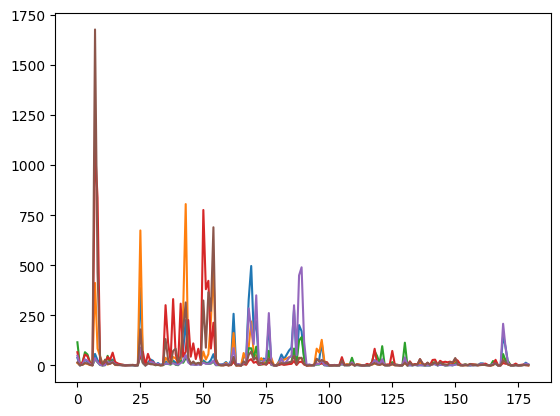

In [90]:
   # Sort centroids and labels
for kidx in range(k):
    centroids_R[kidx][:] = np.mean(conn_avg_R[clustering_R.labels_ == kidx][:], axis=0)
sorted_labels = pairwise_distances_argmin(centroids_R, centroids_L)
temp = clustering_R.labels_.copy()
temp[:] = k + 1
for kidx, new_label in enumerate(sorted_labels):
    temp[np.argwhere(clustering_R.labels_ == kidx)] = new_label
clustering_R.labels_ = temp.copy()
del temp

# Get features for each label and average over voxwels
for kidx in range(k):
    centroids_R[kidx][:] = np.mean(conn_avg_R[clustering_R.labels_ == kidx][:], axis=0)
    
    # Plot for centroid
    plt.plot(centroids_R[kidx])

# use lh_mmp to map to the maximal region from each centroid
target_labels_R = np.argmax(centroids_R, 0) + 1

#lh_mmp indices are from 1 to 180 (0 is bgnd), so:
centroid_cortex_R = target_labels_R[rh_mmp-1]
centroid_cortex_R[np.argwhere(rh_mmp == 0)] = 0

In [91]:
# Download fsaverage surface
fsaverage_data = nilearn.datasets.fetch_surf_fsaverage(
    mesh="fsaverage",
    data_dir="../resources/fsaverage"
)

#### Seed

In [92]:
seed_labels_vol_R = np.zeros(mask_R.shape)
seed_labels_vol_R[mask_R > 0] = clustering_R.labels_ + 1 #add a 1 so label 0 is diff from bgnd
seed_labels_nib_R = nib.Nifti1Image(seed_labels_vol_R, affine_R)

bg_nib_R = nib.load('/home/ROBARTS/tkai/graham/projects/ctb-akhanf/jclau/zona_OSF/OSF/SNSX32NLin2020Asym/sub-SNSX32NLin2020Asym_T1map.nii.gz')

In [93]:
# Slices need to be updated
seed_labels_crop_R = seed_labels_nib_R.slicer[140:180, 130:160, 80:120]
bg_crop_R = bg_nib_R.slicer[140:180, 130:160, 0:40]

## Figures

In [94]:
view_R = nilearn.plotting.view_surf(surf_mesh=fsaverage_data.get("pial_right"),
                                  surf_map=centroid_cortex_R,
                                  cmap=custom_cmap,
                                  vmin=0, vmax=k,
                                  symmetric_cmap=False,
                                  colorbar_fontsize=15)
view_R.open_in_browser()

In [33]:
# Use cropped image
view_R = nilearn.plotting.view_img(
    stat_map_img=seed_labels_nib_R,
    bg_img=None,
    cmap=custom_cmap,
    vmin=0, vmax=k,
    symmetric_cmap=False,
    threshold=None,
    colorbar_fontsize=15,
    draw_cross=False,
)

view_R.open_in_browser()

### Right

In [ ]:
data_R = np.load(f"{DATA_PATH}/{DATA_FNAME}");

conn_group = data_R['conn_group']
mask = data_R['mask']
affine = data_R['affine']

# Concat subjects
conn_group_m = np.moveaxis(conn_group, 0, 2)
conn_concat = conn_group_m.reshape(
    [conn_group_m.shape[0], conn_group_m.shape[1]*conn_group_m.shape[2]]
)

In [ ]:
# Run spectral clustering
method = 'spectralcosine'
dist = 'cosine'
k = 6 #@param {type:"slider", min:0, max:50, step:1}

clustering = SpectralClustering(
    n_clusters=k, 
    assign_labels="discretize",
    random_state=1,
    affinity=dist,
).fit(conn_concat)

In [ ]:
# avg over subjects (for cluster centroid visualization over cortex)
conn_avg =  np.squeeze(np.mean(conn_group_m, 2))

# Cluster
ntargets = conn_group.shape[2]
centroids = np.zeros((k,ntargets))

print(f"shape conn_avg: {conn_avg.shape}")
print(f"shape conn_concat: {conn_concat.shape}")

shape conn_avg: (1669, 180)
shape conn_concat: (1669, 31140)


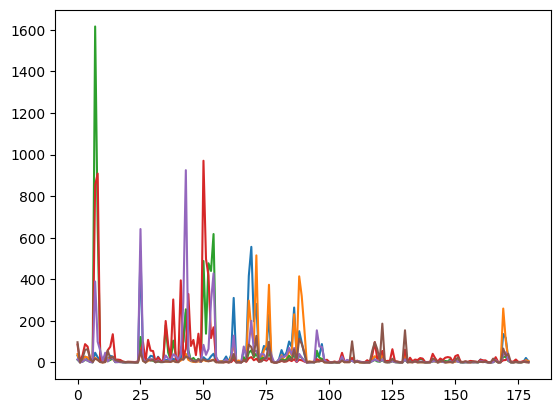

In [ ]:
# Get features for each label and average over voxwels
for kidx in range(k):
    centroids[kidx][:] = np.mean(conn_avg[clustering.labels_ == kidx][:], axis=0)
    
    # Plot for centroid
    plt.plot(centroids[kidx])

# use lh_mmp to map to the maximal region from each centroid
target_labels = np.argmax(centroids, 0) + 1

#lh_mmp indices are from 1 to 180 (0 is bgnd), so:
centroid_cortex = target_labels[lh_mmp-1]

In [ ]:
# Download fsaverage surface
fsaverage_data = nilearn.datasets.fetch_surf_fsaverage(
    mesh="fsaverage",
    data_dir="../resources/fsaverage"
)

#### Seed

In [ ]:
seed_labels_vol = np.zeros(mask.shape)
seed_labels_vol[mask > 0] = clustering.labels_ + 1 #add a 1 so label 0 is diff from bgnd
seed_labels_nib = nib.Nifti1Image(seed_labels_vol,affine)

bg_nib = nib.load('/home/ROBARTS/tkai/graham/projects/ctb-akhanf/jclau/zona_OSF/OSF/SNSX32NLin2020Asym/sub-SNSX32NLin2020Asym_T1map.nii.gz')

In [ ]:
# Slices need to be updated
seed_labels_crop = seed_labels_nib.slicer[130:160, 140:180, 80:120]
bg_crop = bg_nib.slicer[140:180, 130:160, 80:180]

## Figures

In [15]:
view = nilearn.plotting.view_surf(surf_mesh=fsaverage_data.get("pial_right"),
                                  surf_map=centroid_cortex,
                                  cmap='tab10',
                                  vmin=0, vmax=k,
                                  symmetric_cmap=False,
                                  colorbar_fontsize=15)
view.open_in_browser()

In [17]:
# Use cropped image
view = nilearn.plotting.view_img(
    stat_map_img=seed_labels_crop,
    bg_img=None,
    cmap="tab10",
    vmin=0, vmax=k,
    symmetric_cmap=False,
    threshold=None,
    colorbar_fontsize=15,
    draw_cross=False,
)

view.open_in_browser()